In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import shutil
  
file_count = sum(len(filenames) for _, _, filenames in os.walk('/kaggle/input'))
print(f"Number of files in the input folder: {file_count}")

folder_to_clear = '/kaggle/working/'
if os.path.exists(folder_to_clear):
    for filename in os.listdir(folder_to_clear):
        file_path = os.path.join(folder_to_clear, filename)
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
print("Working folder cleared successfully.")

Number of files in the input folder: 6950
Working folder cleared successfully.


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings

warnings.filterwarnings('ignore')

ROOT_PATH = '/kaggle/input/cityscapes-image-pairs/cityscapes_data/'
TRAIN_PATH = os.path.join(ROOT_PATH, 'train')
VAL_PATH = os.path.join(ROOT_PATH, 'val')

train_files = os.listdir(TRAIN_PATH)
val_files = os.listdir(VAL_PATH)

print(f" Training Images: {len(train_files)}")
print(f" Validation Images: {len(val_files)}")

2025-12-09 10:22:29.128649: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765275749.318036      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765275749.367960      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

 Training Images: 2975
 Validation Images: 500


In [3]:
def remove_corrupted_images(folder_path):
    removed = 0
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        try:
            img = cv2.imread(file_path)
            if img is None or img.size == 0:
                print(f" Corrupted image deleted: {filename}")
                os.remove(file_path)
                removed += 1
        except:
            print(f" Error reading image: {filename}")
            os.remove(file_path)
            removed += 1

    print(f"\nTotal corrupted images removed from {folder_path}: {removed}")


print("Checking training images...")
remove_corrupted_images(TRAIN_PATH)

print("\nChecking validation images...")
remove_corrupted_images(VAL_PATH)

Checking training images...

Total corrupted images removed from /kaggle/input/cityscapes-image-pairs/cityscapes_data/train: 0

Checking validation images...

Total corrupted images removed from /kaggle/input/cityscapes-image-pairs/cityscapes_data/val: 0


In [4]:
def check_dataset_balance(path, name):
    files = os.listdir(path)
    print(f"\n Checking {name} dataset")

    sizes = []
    for f in files:
        img = cv2.imread(os.path.join(path, f))
        if img is not None:
            sizes.append(img.shape)

    sizes = np.array(sizes)

    unique_shapes = np.unique(sizes, axis=0)

    print(f" Total images: {len(files)}")
    print(f" Unique image shapes: {len(unique_shapes)}")

    if len(unique_shapes) > 1:
        print("\n Dataset contains inconsistent image shapes:")
        for s in unique_shapes:
            print(" -", tuple(s))
    else:
        print(" All images have consistent dimensions:", unique_shapes[0])


check_dataset_balance(TRAIN_PATH, "Training")
check_dataset_balance(VAL_PATH, "Validation")

print("\nTrain/Validation ratio =", len(train_files), "/", len(val_files))


 Checking Training dataset
 Total images: 2975
 Unique image shapes: 1
 All images have consistent dimensions: [256 512   3]

 Checking Validation dataset
 Total images: 500
 Unique image shapes: 1
 All images have consistent dimensions: [256 512   3]

Train/Validation ratio = 2975 / 500


In [5]:
def load_and_split_image(image_path):

    img = tf.io.read_file(image_path)
    
    img = tf.image.decode_jpeg(img)
    
    img = tf.cast(img, tf.float32)

    w = tf.shape(img)[1] 
    w = w // 2
    
    input_image = img[:, :w, :] 

    mask_image = img[:, w:, :]
    
    input_image = input_image / 255.0
    mask_image = mask_image / 255.0
    
    return input_image, mask_image

print("The image loading and detachment function has been successfully built")

The image loading and detachment function has been successfully built


I0000 00:00:1765275793.636599      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765275793.637294      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


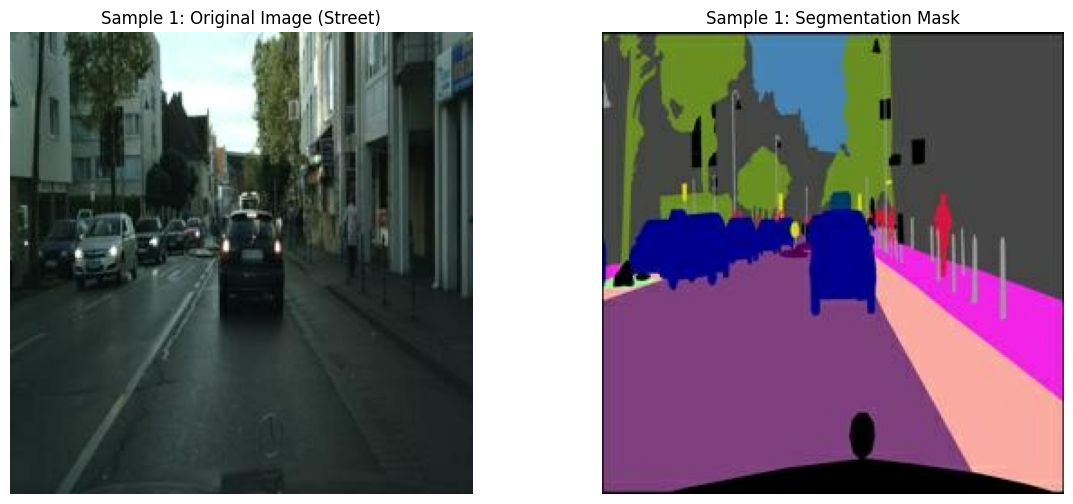

--------------------------------------------------------------------------------------------------------------------------------------


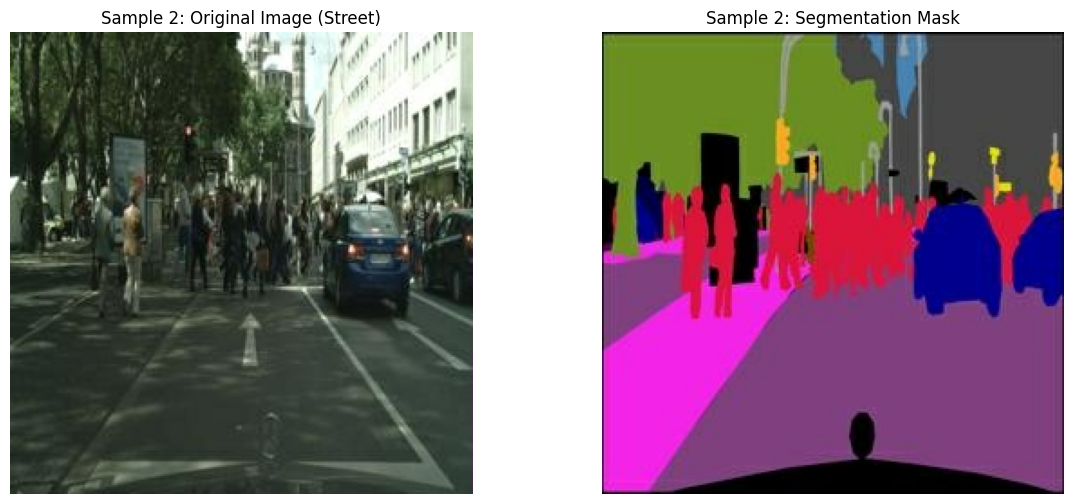

--------------------------------------------------------------------------------------------------------------------------------------


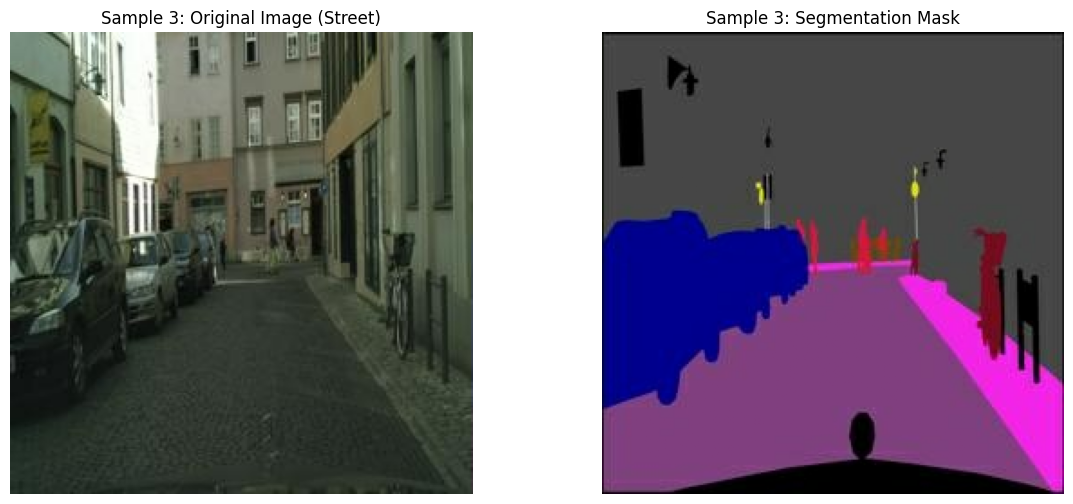

--------------------------------------------------------------------------------------------------------------------------------------


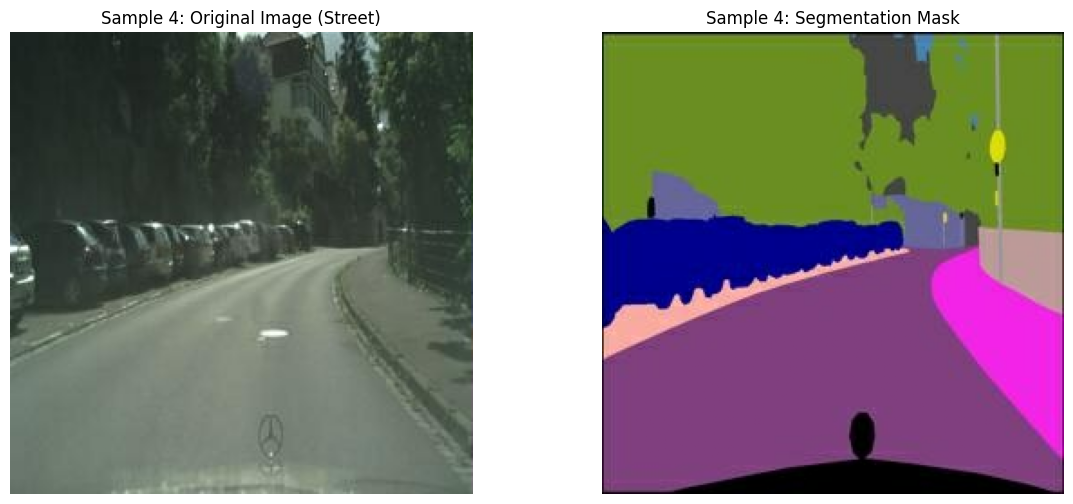

--------------------------------------------------------------------------------------------------------------------------------------


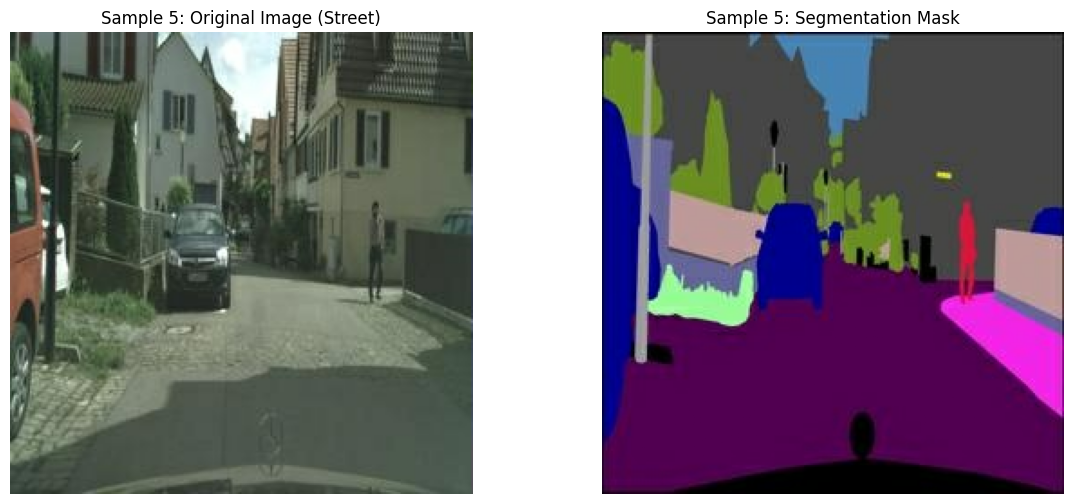

--------------------------------------------------------------------------------------------------------------------------------------


In [6]:
import random 

random_samples = random.sample(train_files, 5)

for i, filename in enumerate(random_samples):
    
    full_path = os.path.join(TRAIN_PATH, filename)
    
    input_img, mask_img = load_and_split_image(full_path)
    
    plt.figure(figsize=(14, 6)) 
    
    plt.subplot(1, 2, 1)
    plt.title(f"Sample {i+1}: Original Image (Street)")
    plt.imshow(input_img)
    plt.axis('off') 
    
    plt.subplot(1, 2, 2)
    plt.title(f"Sample {i+1}: Segmentation Mask")
    plt.imshow(mask_img)
    plt.axis('off')
    
    plt.show()
    print("-" * 134) 

In [7]:
mapping_dict = {
    (128, 64, 128): 1, (244, 35, 232): 1, 
    (70, 70, 70): 2, (102, 102, 156): 2, (190, 153, 153): 2, 
    (153, 153, 153): 3, (250, 170, 30): 3, (220, 220, 0): 3,   
    (107, 142, 35): 4, (152, 251, 152): 4, 
    (70, 130, 180): 5,  
    (220, 20, 60): 6, (255, 0, 0): 6,     
    (0, 0, 142): 7, (0, 0, 70): 7, (0, 60, 100): 7, (0, 0, 230): 7, (119, 11, 32): 7 
}

def rgb_to_class(mask):
    mask = tf.cast(mask * 255, tf.int32)

    shape = tf.shape(mask)
    h, w = shape[0], shape[1]
    
    class_mask = tf.zeros((h, w), dtype=tf.int32)
    
    tolerance = 40 
    
    for color, class_id in mapping_dict.items():
        color_tensor = tf.constant(color, dtype=tf.int32)
        diff = tf.abs(mask - color_tensor)
        mean_diff = tf.reduce_mean(diff, axis=-1)
        match = mean_diff < tolerance
        class_mask = tf.where(match, class_id, class_mask)
        
    class_mask = tf.expand_dims(class_mask, axis=-1)
    return class_mask

def process_data(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img)
    img = tf.cast(img, tf.float32)
    
    w = tf.shape(img)[1] // 2
    input_image = img[:, :w, :] 
    mask_image = img[:, w:, :]
    
    input_image = tf.image.resize(input_image, (256, 256))
    mask_image = tf.image.resize(mask_image, (256, 256), method='nearest')
    
    input_image = input_image / 255.0
    mask_image = rgb_to_class(mask_image / 255.0)
    
    input_image.set_shape([256, 256, 3])
    mask_image.set_shape([256, 256, 1])
    
    return input_image, mask_image

print("The functions have been corrected to be compatible with Graph Mode.")

The functions have been corrected to be compatible with Graph Mode.


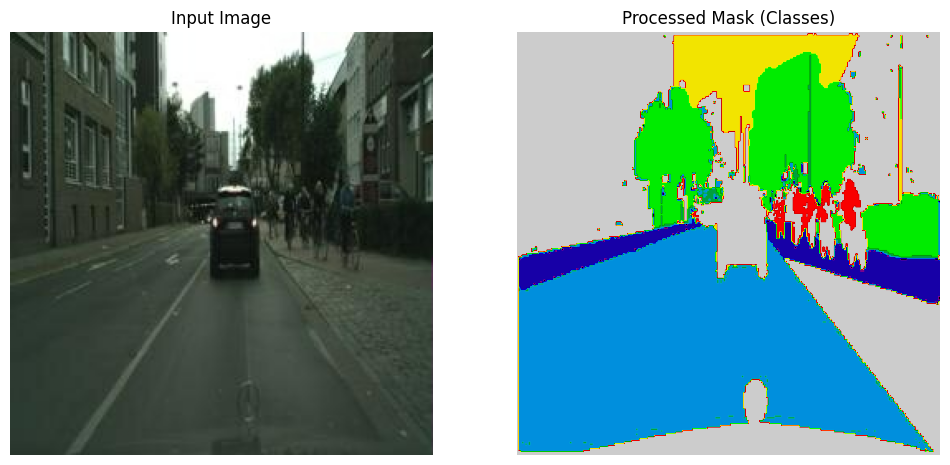

 The numbers in this image (Classes Found): [0 1 2 3 4 5 6 7]
Test successful: The model successfully converted colors into multiple categories.


In [8]:
random_file = random.choice(train_files)
sample_path = os.path.join(TRAIN_PATH, random_file) 

inp, msk = process_data(sample_path)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(inp)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Processed Mask (Classes)")
plt.imshow(msk[:, :, 0] * 30, cmap='nipy_spectral') 
plt.axis('off')

plt.show()

unique_classes = np.unique(msk.numpy())
print(f" The numbers in this image (Classes Found): {unique_classes}")

if len(unique_classes) > 2:
    print("Test successful: The model successfully converted colors into multiple categories.")
else:
    print("Warning: The model did not find enough classes. Try running the code again on a different image.")

In [9]:
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

def create_dataset(image_paths, is_training=True):
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(process_data, num_parallel_calls=AUTOTUNE)
    
    if is_training:
        dataset = dataset.shuffle(buffer_size=1000)
    
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

train_img_paths = [os.path.join(TRAIN_PATH, fname) for fname in train_files]
val_img_paths = [os.path.join(VAL_PATH, fname) for fname in val_files]

print("Building Datasets...")
train_dataset = create_dataset(train_img_paths, is_training=True)
val_dataset = create_dataset(val_img_paths, is_training=False)
print("The pipelines have been successfully built.")

for x, y in train_dataset.take(1):
    print(f"Dataset Ready: Images {x.shape}, Masks {y.shape}")

Building Datasets...
The pipelines have been successfully built.
Dataset Ready: Images (16, 256, 256, 3), Masks (16, 256, 256, 1)


In [10]:
for images, masks in train_dataset.take(1):
    print("\n Checking the dimensions of the batch(Batch Shape Check):")
    print(f"   - Images Shape: {images.shape} ")
    print(f"   - Masks Shape:  {masks.shape} ")
    
    if images.shape[-1] == 3 and masks.shape[-1] == 1:
        print("\n The dimensions are perfectly accurate. We are ready to build the model. (U-Net)!")
    else:
        print("\n There is an error in the dimensions; please refer to the previous steps..")


 Checking the dimensions of the batch(Batch Shape Check):
   - Images Shape: (16, 256, 256, 3) 
   - Masks Shape:  (16, 256, 256, 1) 

 The dimensions are perfectly accurate. We are ready to build the model. (U-Net)!


In [11]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def build_unet_model(input_shape=(256, 256, 3), num_classes=8):
    inputs = Input(input_shape)

    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

model = build_unet_model()

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

print(" The model was successfully built and assembled.")
model.summary()

 The model was successfully built and assembled.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ dropout_2[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ dropout_3[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]  

 Total params: 31,032,200 (118.38 MB)

 Trainable params: 31,032,200 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
checkpoint_path = "cityscapes_unet_model.keras"

callbacks = [
   
    ModelCheckpoint(checkpoint_path, verbose=1, save_best_only=True, monitor='val_loss'),
    
    EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
]

print("Training is starting... (You can go get your coffee now)")

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=150,  
    callbacks=callbacks
)

print("Training is over!")

Training is starting... (You can go get your coffee now)
Epoch 1/150


I0000 00:00:1765275848.420946      60 service.cc:148] XLA service 0x7df98802b2e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765275848.421848      60 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765275848.421866      60 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1765275849.039454      60 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1765275849.497331      60 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-12-09 10:24:15.128573: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=0} for conv (f32[16,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,128,128,128]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_targ

185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - accuracy: 0.4963 - loss: 1.5852

W0000 00:00:1765276060.375002      60 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
E0000 00:00:1765276078.320156      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765276078.555319      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765276087.656548      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765276087.969099      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:176527

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4969 - loss: 1.5829   

W0000 00:00:1765276130.433725      61 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1765276157.457105      62 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
E0000 00:00:1765276166.594766      62 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765276166.816232      62 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



Epoch 1: val_loss improved from inf to 0.83005, saving model to cityscapes_unet_model.keras
186/186 ━━━━━━━━━━━━━━━━━━━━ 339s 1s/step - accuracy: 0.4975 - loss: 1.5807 - val_accuracy: 0.7445 - val_loss: 0.8301 - learning_rate: 0.0010
Epoch 2/150
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 789ms/step - accuracy: 0.7616 - loss: 0.7502
Epoch 2: val_loss improved from 0.83005 to 0.69468, saving model to cityscapes_unet_model.keras
186/186 ━━━━━━━━━━━━━━━━━━━━ 169s 847ms/step - accuracy: 0.7617 - loss: 0.7500 - val_accuracy: 0.7752 - val_loss: 0.6947 - learning_rate: 0.0010
Epoch 3/150
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.7983 - loss: 0.6400
Epoch 3: val_loss improved from 0.69468 to 0.61852, saving model to cityscapes_unet_model.keras
186/186 ━━━━━━━━━━━━━━━━━━━━ 169s 847ms/step - accuracy: 0.7984 - loss: 0.6400 - val_accuracy: 0.8092 - val_loss: 0.6185 - learning_rate: 0.0010
Epoch 4/150
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.8248 - loss: 0.5688
Epoch 4: val_los

In [13]:
def get_metrics(dataset_name, dataset, model):
    print(f" Calculating the measurements {dataset_name}...")
    
    loss, acc = model.evaluate(dataset, verbose=0)
    
    iou_metric = tf.keras.metrics.MeanIoU(num_classes=8)
    
    for images, masks in dataset:
        preds = model.predict(images, verbose=0)
        preds = tf.argmax(preds, axis=-1) 
        masks = tf.cast(masks, tf.int32)  
        iou_metric.update_state(masks, preds)
        
    mean_iou = iou_metric.result().numpy()
    
    dice_score = (2 * mean_iou) / (1 + mean_iou)
    
    return [acc, loss, mean_iou, dice_score]

train_res = get_metrics("Training Data", train_dataset, model)
val_res = get_metrics("Validation Data", val_dataset, model)

df_final = pd.DataFrame({
    'Metric': ['Pixel Accuracy', 'Loss', 'Mean IoU', 'Dice Score)'],
    'Training': [f"{x:.4f}" for x in train_res],
    'Validation': [f"{x:.4f}" for x in val_res]
})

print("\n" + "="*50)
print("FINAL PROFESSIONAL RESULTS")
print("="*50)
print(df_final.to_string(index=False))
print("="*50)

 Calculating the measurements Training Data...


W0000 00:00:1765280108.244542      60 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


 Calculating the measurements Validation Data...

FINAL PROFESSIONAL RESULTS
        Metric Training Validation
Pixel Accuracy   0.9039     0.8739
          Loss   0.3021     0.4307
      Mean IoU   0.6031     0.5387
   Dice Score)   0.7525     0.7002


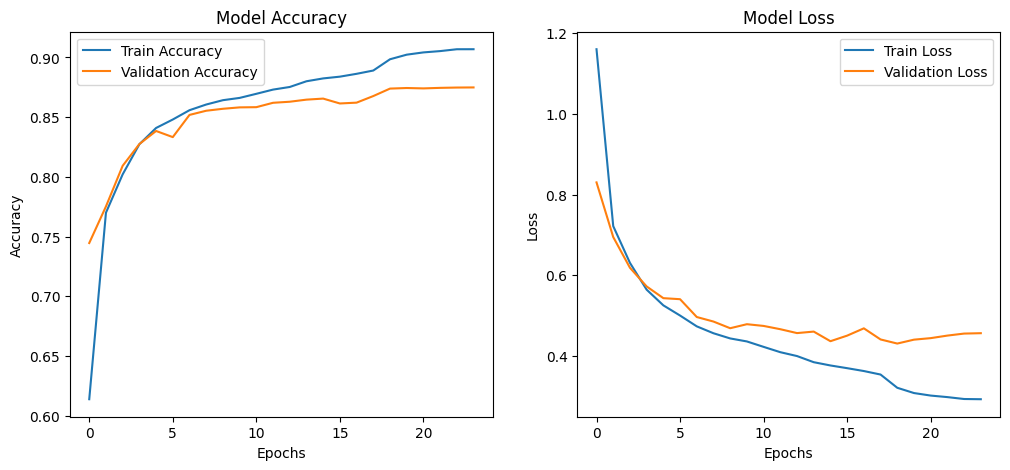

In [14]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

 Visualizing Predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


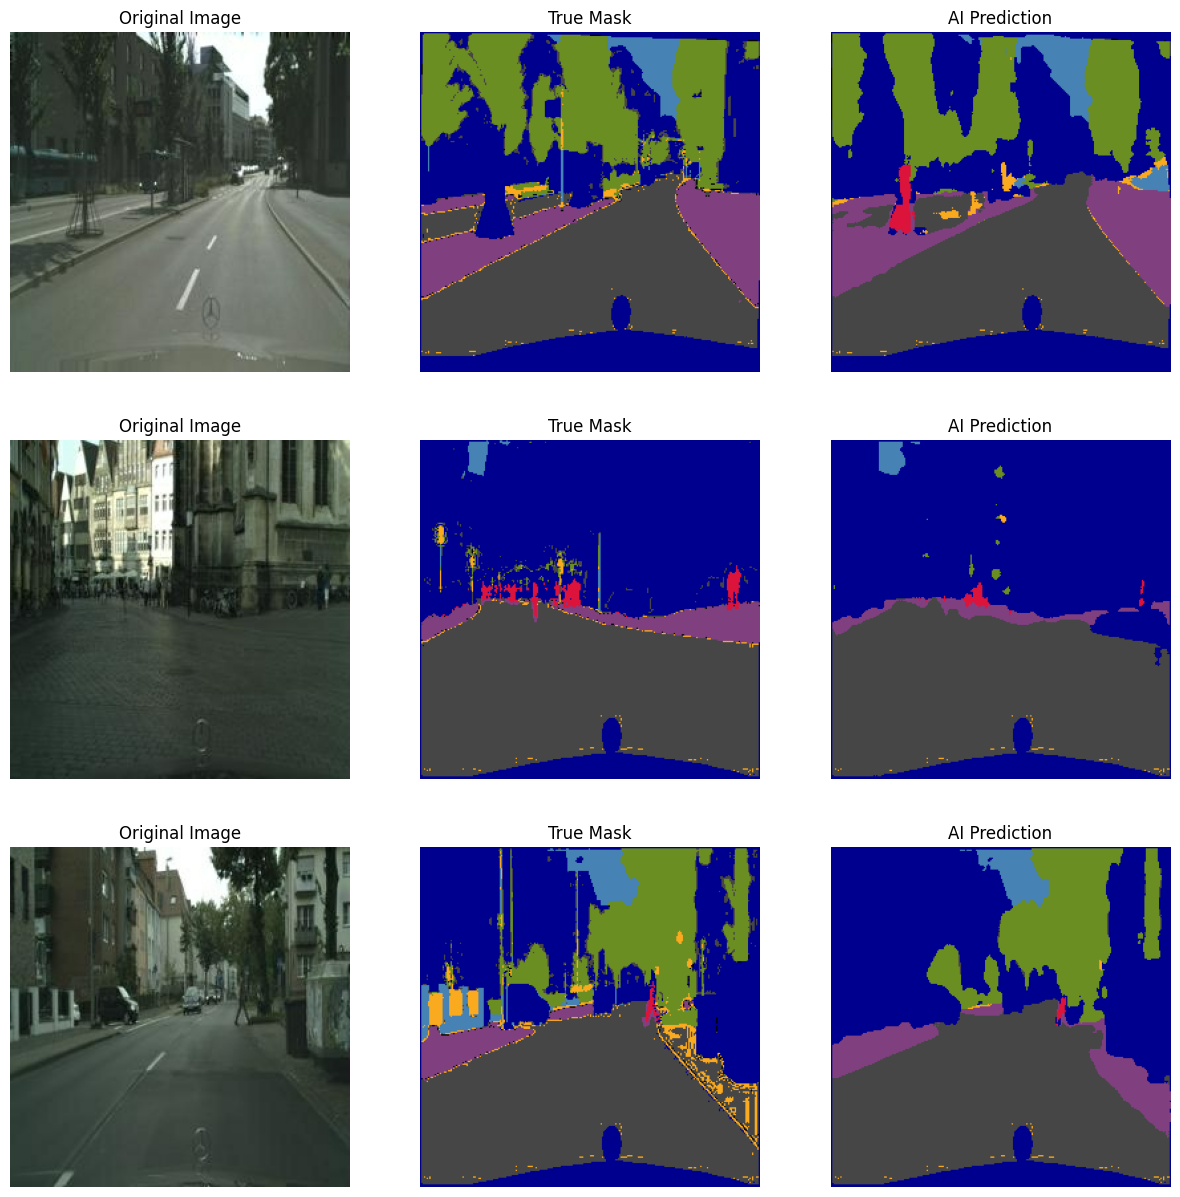

In [15]:
def create_colored_mask(mask):
    colors = np.array([
        [0, 0, 0], [128, 64, 128], [70, 70, 70], [250, 170, 30],
        [107, 142, 35], [70, 130, 180], [220, 20, 60], [0, 0, 142]
    ])
    mask_indices = tf.squeeze(mask, axis=-1).numpy()
    mask_indices = np.clip(mask_indices, 0, 7)
    return colors[mask_indices].astype(np.uint8)

def show_predictions(dataset, num=3):
    plt.figure(figsize=(15, 5 * num))
    for image, mask in dataset.take(1):
        pred_mask = model.predict(image)
        pred_mask = tf.argmax(pred_mask, axis=-1)
        pred_mask = tf.expand_dims(pred_mask, axis=-1)
        
        for i in range(num):
            plt.subplot(num, 3, i*3 + 1)
            plt.title("Original Image")
            plt.imshow(image[i])
            plt.axis('off')
            
            plt.subplot(num, 3, i*3 + 2)
            plt.title("True Mask")
            plt.imshow(create_colored_mask(mask[i]))
            plt.axis('off')
            
            plt.subplot(num, 3, i*3 + 3)
            plt.title("AI Prediction")
            plt.imshow(create_colored_mask(pred_mask[i]))
            plt.axis('off')
    plt.show()

print(" Visualizing Predictions...")
show_predictions(val_dataset, num=3)

In [16]:
print("Generating Demo Video...")

output_video_path = 'cityscapes_demo.avi' 
fourcc = cv2.VideoWriter_fourcc(*'MJPG') 
fps = 10
frame_size = (256, 256)

video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, frame_size)

colors = np.array([
    [0, 0, 0], [128, 64, 128], [70, 70, 70], [250, 170, 30],
    [107, 142, 35], [70, 130, 180], [220, 20, 60], [0, 0, 142]
])

count = 0
print("Processing... Please wait...")

for image, mask in val_dataset.unbatch().take(100):
    pred_mask = model.predict(tf.expand_dims(image, axis=0), verbose=0)
    pred_mask = tf.argmax(pred_mask, axis=-1)[0].numpy()
    
    colored_mask = colors[pred_mask].astype(np.uint8)
    original_img = (image.numpy() * 255).astype(np.uint8)
    
    colored_mask_bgr = cv2.cvtColor(colored_mask, cv2.COLOR_RGB2BGR)
    original_img_bgr = cv2.cvtColor(original_img, cv2.COLOR_RGB2BGR)
    
    original_img_bgr = cv2.resize(original_img_bgr, frame_size)
    colored_mask_bgr = cv2.resize(colored_mask_bgr, frame_size)
    
    overlay = cv2.addWeighted(original_img_bgr, 0.6, colored_mask_bgr, 0.4, 0)
    
    video_writer.write(overlay)
    
    count += 1
    if count % 20 == 0:
        print(f"The {count} frame has been processed...")

video_writer.release()
print(f"Video saved successfully: {output_video_path}")
print("You can now load and play it on any video player.")

Generating Demo Video...
Processing... Please wait...
The 20 frame has been processed...
The 40 frame has been processed...
The 60 frame has been processed...
The 80 frame has been processed...
The 100 frame has been processed...
Video saved successfully: cityscapes_demo.avi
You can now load and play it on any video player.


The live show is being prepared...
The presentation is ready:


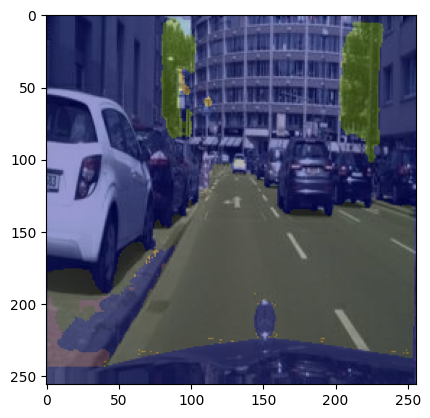

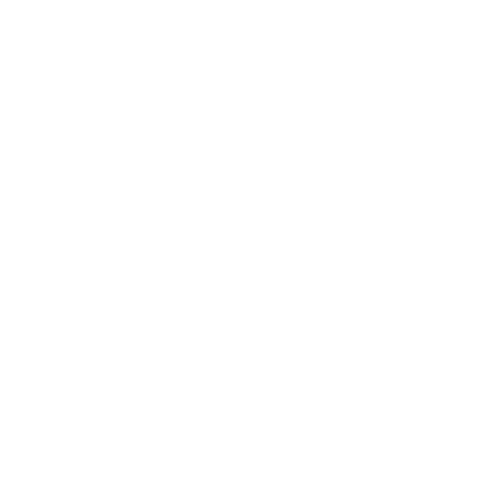

In [17]:
import matplotlib.animation as animation
from IPython.display import HTML

frames = []
print("The live show is being prepared...")

for image, mask in val_dataset.unbatch().take(50): 
    pred_mask = model.predict(tf.expand_dims(image, axis=0), verbose=0)
    pred_mask = tf.argmax(pred_mask, axis=-1)[0].numpy()
    
    colored_mask = colors[pred_mask].astype(np.uint8)
    original_img = (image.numpy() * 255).astype(np.uint8)
    
    overlay = cv2.addWeighted(original_img, 0.6, colored_mask, 0.4, 0)
    frames.append([plt.imshow(overlay, animated=True)])

fig = plt.figure(figsize=(6, 6))
plt.axis('off')

ani = animation.ArtistAnimation(fig, frames, interval=100, blit=True, repeat_delay=1000)

print("The presentation is ready:")
HTML(ani.to_jshtml())

In [18]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT] 
tflite_model = converter.convert()

tflite_path = 'cityscapes_model.tflite'
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

tflite_size = os.path.getsize(tflite_path) / (1024 * 1024)
print(f" TFLite file size (for mobile and web): {tflite_size:.2f} MB")

INFO:tensorflow:Assets written to: /tmp/tmpr2mbk6rj/assets


INFO:tensorflow:Assets written to: /tmp/tmpr2mbk6rj/assets


Saved artifact at '/tmp/tmpr2mbk6rj'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 256, 256, 8), dtype=tf.float32, name=None)
Captures:
  138513384563024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138513384568016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138513384567632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138513384568976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138513384568208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138513384568592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138513384568400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138513384566288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138513384570704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138512258450832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1385

W0000 00:00:1765280281.106351      20 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1765280281.106387      20 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1765280281.137460      20 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


 TFLite file size (for mobile and web): 29.71 MB
